## Problem Statement

Coursera is a massive open online course (MOOC) platform that offers online courses, certifcations in collaboration with other recognised universities and business organisations. As the courses are conducted online, they are highly accessible to students around the world. 

There has been a surge in MOOC participation and service providers, and the MOOC industry is forecasted to reach USD 18925.18 million and 100 million learners by 2026. With the rise of the 4th Industrial revolution, more employers are upgrading their skillsets to deal with the ever-changing technological disruption in their industries. In addition, due to the unfortunate outbreak of Covid-19 in 2020, momentum towards online learning as exponentially grown as it reduces the risk associated with in-person teaching.

As MOOCs are conducted remotely, feedback from the course content are in the form of `rating` and `reviews` submitted by students.
In this project, we attempt to analyse what are the `reviews` that leads to the different `rating` *(For example, why did this reviewer rate 5(highest)) but the other reviewer rate less than 5* and find the best classification models that can classify submitted `reviews` to their corresponding `rating`.From understanding what words help to classify 5.0 rating, we can improve MOOC satisfaction.

In addition, this project also attempt to generate fake positive reviews using Recurrent Neural Network.

## Executive Summary

In this capstone project, datasets **Coursera_courses.csv** and **Coursera_reviews.csv** are used from [Kaggle](https://www.kaggle.com/imuhammad/course-reviews-on-coursera?select=Coursera_reviews.csv). **Coursera_courses.csv** contains data like the course name and institutions while **Coursera_reviews.csv** contain reviews and rating left by each reviewer.
Both of the datasets are merged on the 'key' column. Now the dataset is combined into 1 dataframe.

There were reviews left in other languages and a combination of NLP libraries are used to translate `reviews` to english.
**Regular Expression** is used to clean up the text. **nltk.corpus** is used to filter out the non-english `reviews`.
**SpaCy** is used to detect the different languages. **google_trans_new** is a free python API for google translate,
the non-english `reviews` are translated in separate batches to prevent exceeding the request limit.

After the translation is complete, duplicated posts are removed and minimum 'count of words'= 5 are used. `Reviews` with `rating` 5.0 are mapped to 1 while `Reviews` with `rating`less than 5.0 are mapped to 0. The `reviews` are further preprocessed to remove digits, symbols and url links. `Reviews` with and without `rating` 5 and plotted on **WordClouds** - visual representations of words that give greater prominence to words that appear more frequently. This provides a visual signal of which words may help in classifying the 2 types of reviews. **pyLDAvis** is also used to interprete possible topics from the `reviews`.

The dataframe is then split into random train and test subsets using train_test_split.The `reviews` are preprocessed further using Porter Stemmer to generate the root form of the inflected words. Countvectorizer is used to convert the text in `reviews` to numerical data before using different Classification models for binary classification.

There were many Classification models used: Logistic Regression, MultinomialNB Classification, Decision Tree Classifier, Random Forest Classifier, AdaBoost Classifier, XGBoost Classifier. With high accuracy score and ability to generalise to unseen data compared to other models (the delta between train and test accuracy score) and low False Positive rate as our consideration, **Multinomial NB** showed the high accuracy in classifying the `Reviews` with `rating` 5.0 (mapped to 1) and `Reviews` with `rating`less than 5.0 (mapped to 0) and has the lowest False Positive rate.

In addition to classification of  `reviews`, this Capstone project also explored Text generation using Recurrent Neural Network(RNN). With tutorials from [keras.io](https://keras.io/) and fine-tuning, the text generated were easily understood and were able to generate reviews-like text.Recurrent Neural Network with 2 LSTM layer with Dropout of 0.2 is found to have the most readable text. However, more research and fine-tuning are required to produce grammatically correct reviews.

### Content
- [1. Standard Imports](#1.-Standard-Imports)
- [2. Data Import for Coursera_courses.csv and Coursera_reviews.csv](#2.-Data-Import)
- [3. Merging Datasets into 1 DataFrame](#3.-Merging-Datasets-into-1-DataFrame)
- [4. Addressing the null values](#4.-Addressing-the-null-values)
- [5. Understanding the Dataset](#5.-Understanding-the-Dataset)
  - [5.1 name](#5.1-name)
  - [5.2 institution](#5.2-institution)
  - [5.3 course_url & course_id](#5.3-course-url-&-course-id)
  - [5.4 reviews](#5.4-reviews)
  - [5.5 reviewers](#5.5-reviewers)
  - [5.6 date_reviews](#5.6-date-reviews)
  - [5.7 rating](#5.7-rating)
- [6. Insights from entire Dataset](#6.-Insights-from-entire-Dataset)
- [7. Data Export to csv file](#7.-Data-Export-to-csv-file)

### 1. Standard Imports

In [1]:
# https://www.kaggle.com/imuhammad/course-reviews-on-coursera?select=Coursera_reviews.csv

# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import datetime
from datetime import datetime

### 2. Data Import

In [2]:
courses = pd.read_csv('Coursera_courses.csv')
courses.head()

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being
3,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals
4,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,google-cbrs-cpi-training


In [3]:
reviews = pd.read_csv('Coursera_reviews.csv')
reviews.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


### 3. Merging Datasets into 1 DataFrame

In [11]:
# merge both course and reviews together
# use outer join to include null values
df = pd.merge(courses, reviews, how='outer', left_on='course_id', right_on='course_id')

# there is 1.4 million rows and 8 columns
df.shape

(1454730, 8)

In [12]:
# remove duplicate posts first
df.drop_duplicates(inplace=True)

# after dropping duplicates, there is 500K+ rows and 8 columns
df.shape

(519966, 8)

After merging the 2 datasets `Coursera_courses.csv` & `Coursera_reviews.csv` and removing duplicated rows:
    The shape of dataframe is (519966, 8)

In [13]:
# check the dtype of columns in df dataframe
# check the presence non-null values in df, this will be addressed later
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519966 entries, 0 to 1454729
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   name          519966 non-null  object 
 1   institution   519966 non-null  object 
 2   course_url    519966 non-null  object 
 3   course_id     519966 non-null  object 
 4   reviews       519891 non-null  object 
 5   reviewers     519947 non-null  object 
 6   date_reviews  519947 non-null  object 
 7   rating        519947 non-null  float64
dtypes: float64(1), object(7)
memory usage: 35.7+ MB


In [14]:
# list of columns, df.columns
unique_value = list()

for col in df:
    unique_value.append(len(df[col].unique()))

pd.DataFrame({'columns': df.columns,
              'count of unique value': unique_value})

,columns,count of unique value
0,name,622
1,institution,134
2,course_url,623
3,course_id,623
4,reviews,458278
5,reviewers,287809
6,date_reviews,1893
7,rating,6


 - `name`,`institution`, `course_ur`,`course_id` they refer to course data.
 - `reviews` are unique as they are different sentences
 - `rating` refers to rating 1 to 5

In [15]:
# .describe() only applies to numerical columns
df.describe()

,rating
count,519947.000000
mean,4.689243
std,0.710876
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [16]:
# finding out which columns have null values and how many are null
df.isnull().sum()

name             0
institution      0
course_url       0
course_id        0
reviews         75
reviewers       19
date_reviews    19
rating          19
dtype: int64

There are null values and as they do not provide info in terms of `reviews` and `rating` they will be dropped later

In [17]:
# these are currently the value counts for different ratings 
df.groupby('rating')['name'].count()

rating
1.0      6625
2.0      6070
3.0     17733
4.0     81401
5.0    408118
Name: name, dtype: int64

Observe that majority of the `rating` are **positive** with a score of **5.0**

### 4. Addressing the null values

In [20]:
# checking how many 'reviews' are null
display(df[df['reviews'].isnull()].head())

null_pct = round(len(df[df['reviews'].isnull()])/len(df)*100,4)

print(f'{null_pct} % of dataset has no reviews')

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
65678,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals,NaN,By Ritu K,"Aug 04, 2020",4.0
171302,The Bits and Bytes of Computer Networking,Google,https://www.coursera.org/learn/computer-networ...,computer-networking,NaN,By Christopher L J,"Sep 26, 2020",5.0
171311,The Bits and Bytes of Computer Networking,Google,https://www.coursera.org/learn/computer-networ...,computer-networking,NaN,By Jerold K G,"Jun 10, 2020",5.0
193282,AI For Everyone,DeepLearning.AI,https://www.coursera.org/learn/ai-for-everyone,ai-for-everyone,NaN,By t. d k,"Jun 27, 2020",5.0
193287,AI For Everyone,DeepLearning.AI,https://www.coursera.org/learn/ai-for-everyone,ai-for-everyone,NaN,By KODATHALA S V,"May 29, 2020",5.0


0.0144 % of dataset has no reviews


In [24]:
# noticed that reviews with null values are also null in other columns
df[(df['reviews'].isnull()) &  (df['date_reviews'].isnull())][['reviews', 'reviewers', 'date_reviews', 'rating']].head()

,reviews,reviewers,date_reviews,rating
573844,NaN,NaN,NaN,NaN
692164,NaN,NaN,NaN,NaN
759012,NaN,NaN,NaN,NaN
885547,NaN,NaN,NaN,NaN
1025930,NaN,NaN,NaN,NaN


In [28]:
# removing null 'reviews'
df = df[df['reviews'].notnull()]

As only 0.0144 % of dataset has no `reviews` and `rating`, these rows will be dropped from the dataframe

In [31]:
# noticed that after removing 'null' reviews the other corresponding rows with null values are removed too
display(df.isnull().sum())

# this is the current shape of our df
print (f'shape of df is {df.shape}, there are {df.shape[0]} rows and {df.shape[1]} columns')

name            0
institution     0
course_url      0
course_id       0
reviews         0
reviewers       0
date_reviews    0
rating          0
dtype: int64

shape of df is (519891, 8), there are 519891 rows and 8 columns


### 5. Understanding the Dataset

In [33]:
# listing the different columns in dataframe
df.columns

Index(['name', 'institution', 'course_url', 'course_id', 'reviews',
       'reviewers', 'date_reviews', 'rating'],
      dtype='object')

#### 5.1 name

In [32]:
# 'name' refers to course name
# seems like the most common courses are related to Python and Machine learning!
pd.DataFrame(df['name'].value_counts()).head(5)

,name
Programming for Everybody (Getting Started with Python),15226
Machine Learning,12677
Neural Networks and Deep Learning,12291
Technical Support Fundamentals,12054
Learning How to Learn: Powerful mental tools to help you master tough subjects,11871


courses related to Python and Machine Learning has the most reviews!

#### 5.2 institution

In [60]:
# 'institution' refers to course name
# University of Michigan offers the most courses on Coursera
pd.DataFrame(df['institution'].value_counts()).head(10)

,institution
University of Michigan,57195
DeepLearning.AI,40323
Google,26933
University of Pennsylvania,25759
IBM,24970
Stanford University,23232
University of California San Diego,21591
Johns Hopkins University,20010
Yale University,19883
Google Cloud,16996


In [73]:
df['University'] = ['University' if 'University' in i else 'Business est' for i in df['institution']]

In [74]:
df['University'].value_counts()

University      283193
Business est    155535
Name: University, dtype: int64

There are more `reviews` for courses from Universities than Business establishments.

#### 5.3 course_url & course_id

In [36]:
pd.DataFrame(df['course_url'].value_counts())

,course_url
https://www.coursera.org/learn/python,15226
https://www.coursera.org/learn/machine-learning,12677
https://www.coursera.org/learn/neural-networks-deep-learning,12291
https://www.coursera.org/learn/technical-support-fundamentals,12054
https://www.coursera.org/learn/learning-how-to-learn,11871
...,...
https://www.coursera.org/learn/social-work-practice-advocating-social-justice-and-change,5
https://www.coursera.org/learn/remote-team-management,5
https://www.coursera.org/learn/the-business-of-product-management-one,5
https://www.coursera.org/learn/entreprise-changement-climatique,2


In [40]:
# 'name' of the course is correlated to their specific url and course_id
pd.DataFrame(df[['name','course_url', 'course_id']].value_counts()).head()

,,,0
name,course_url,course_id,
Programming for Everybody (Getting Started with Python),https://www.coursera.org/learn/python,python,15226
Machine Learning,https://www.coursera.org/learn/machine-learning,machine-learning,12677
Neural Networks and Deep Learning,https://www.coursera.org/learn/neural-networks-deep-learning,neural-networks-deep-learning,12291
Technical Support Fundamentals,https://www.coursera.org/learn/technical-support-fundamentals,technical-support-fundamentals,12054
Learning How to Learn: Powerful mental tools to help you master tough subjects,https://www.coursera.org/learn/learning-how-to-learn,learning-how-to-learn,11871


#### 5.4 reviews

In [41]:
pd.DataFrame(df['reviews'].value_counts()).head()

,reviews
good,3244
Good,2010
Excellent,1308
Great course!,882
great,787


There are many repeated one-word `Reviews`

In [65]:
df['count of words'] = [len(review.split(' ')) for review in df['reviews']]

pd.DataFrame(df['count of words'].value_counts()).head()
# most of the reviews are in 5 words

,count of words
5,19830
4,19589
6,18304
7,17160
8,16361


In [61]:
# reviewed the type of reviews and what information could be retrieved based on 'count of words'
# from less than or equal to 3 words onwards, the words used are not signifcant and may not correlate to their rating
df[df['count of words']<=3].head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words
167,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Hard and dry,By Luis A,"May 03, 2016",1.0,3
168,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,sertificado,By antony y,"May 22, 2017",1.0,1
214,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Certificate is expensive!,By Ivan Č,"Feb 24, 2016",2.0,3
317,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,good so far,By Saleh a h,"Jul 14, 2017",2.0,3
318,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,jhkd,By Kendrashya,"Sep 19, 2020",2.0,1


In [62]:
# from 'count of words' = 4, starts to see reviews that explains their reasoning for rating
df[df['count of words']==4]

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words
165,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,error in assignment subbmisison,By Mannat p S,"May 14, 2020",1.0,4
217,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Assignments are very messy.,By Loftur e,"Sep 17, 2018",2.0,4
313,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,too much impractical shenanigans,By Arnold D,"Aug 04, 2020",2.0,4
316,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Tough for a newbie,By Venkata P K G,"Dec 13, 2017",2.0,4
842,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Submission is very difficult!,By Sonali s,"Oct 07, 2019",3.0,4


In [64]:
# decided to only use reviews with more than or equal to 4 words
df = df[df['count of words']>=4]

shape of df is (438728, 9), there are 438728 rows and 9 columns


In [110]:
df[df['count of words']>=4].sort_values(by='count of words', ascending=False).head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University
1418884,Accounting Analytics,University of Pennsylvania,https://www.coursera.org/learn/accounting-anal...,accounting-analytics,This is my feedback as a Beta-Tester for the c...,By Jan Z,"Jan 05, 2016",4.0,1409,University
1295444,Aprendiendo a aprender: Poderosas herramientas...,University of California San Diego,https://www.coursera.org/learn/aprendiendo-a-a...,aprendiendo-a-aprender,"I will try now a Summary of the whole course, ...",By Javier M,"Oct 10, 2016",5.0,1279,University
1126417,The Arts and Science of Relationships: Underst...,University of Toronto,https://www.coursera.org/learn/human-needs,human-needs,I am a college student who took this course ma...,By Almyn C A,"Aug 29, 2020",4.0,1059,University
104950,Introduction to Psychology,Yale University,https://www.coursera.org/learn/introduction-ps...,introduction-psychology,\n\nIntroduction to Psychology is a journey th...,By Dr.Mohammad K H,"Sep 16, 2020",5.0,1028,University
960900,Fashion as Design,The Museum of Modern Art,https://www.coursera.org/learn/fashion-design,fashion-design,"“A frog in a well cannot discuss the ocean, be...",By gandavarapu s,"May 26, 2020",5.0,982,Business est


In [108]:
df_beta = df.loc[df['reviews'].str.contains("Beta-Tester", case=False)]

df_beta

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University
639128,The Data Scientist’s Toolbox,Johns Hopkins University,https://www.coursera.org/learn/data-scientists...,data-scientists-tools,"I'm doing this training for the second time, n...",By Enrique B,"Dec 04, 2015",4.0,269,University
1086345,Natural Language Processing with Attention Models,DeepLearning.AI,https://www.coursera.org/learn/attention-model...,attention-models-in-nlp,I haven't had similar issues with previous cou...,By Konstantinos K,"Oct 05, 2020",2.0,237,Business est
1418884,Accounting Analytics,University of Pennsylvania,https://www.coursera.org/learn/accounting-anal...,accounting-analytics,This is my feedback as a Beta-Tester for the c...,By Jan Z,"Jan 05, 2016",4.0,1409,University


- Observed that there are reviews left by **beta-testers** for Coursera courses, on inspecting the actual text.
- The reviews left by **beta-testers** are removed

In [112]:
# this review is done by a beta tester
df_beta.loc[639128, 'reviews'][:1000]

'I\'m doing this training for the second time, now as a beta-tester. Particular comments about lecture content, problems, etc. have been put in every lecture.\nGeneral comments, in short:\n1) Related to the new platform and UI design:\n_ It is cleaner and simpler than the previous one. I like it, BUT...\n_ It lacks of some useful features: saving intermediate results in quizzes before submit them; calendar; limited number of subforums.\n_ The most relevant flaw: there are not downloadable versions of lecture slides. Unacceptable! No way to check most of the links we saw in slides (URLs not visible).\n_ Description and steps in course project appear "too packed" together. I prefer the former design.\n2) Related to content:\n_ The course is mainly for preparing students for the rest of data science specialization program. When you said "toolbox" you mean the concrete toolbox you will need to do the program. Some people expect to have a general introduction to data science but that is onl

In [111]:
# this review is done by a beta tester
df_beta.loc[1418884, 'reviews'][0:1000]

'This is my feedback as a Beta-Tester for the course:Week 1I thought that the videos were clear, well organized and flowed well from topic to topic.  There was a clear logic as the professor developed the various ratios. What was missing for me was some in-line quizzes.  Not the “tell me what I just told you type” but rather ones that make you think.  So, for example, in the final video for Week 1, the optional video, instead of just suggesting that the students “play” with the spreadsheet, I think it would be better to give them an actual task or two… “change the assumption about X to <this value>.  What is the impact on the Y ratio?  Why?”  I liked that he showed what numbers needed to be changed to make the share valuation closer to $55.  But rather than just telling us the answer, this would be another opportunity to have the students stop the video and go try it themselves.  With a specific task, it is likely that more students will go and work with the spreadsheet.  This is where

In [104]:
# this is a review asking for better beta testers, but not done by a beta tester
df_beta.loc[1086345,'reviews']

'I haven\'t had similar issues with previous courses by Deeplearning.ai, but with this one I was worried I\'m overly stupid the moment I started, because I noted I was "missing" a lot and was not understanding easily what\'s going on (Note: I have all required background from the ML Course and DL Specialization). Then I saw the existing reviews and was happy to see I\'m not alone to feel like that: - Overly superficial coverage of theory in videos; too many things not explained well (if at all).  For example: last week\'s videos are about... 18 minutes. REALLY? I thought we were talking more complex stuff here. If one can be taught this in 18 minutes, then... oh well...- Lots of "copy-paste  this here" parts in assignments, too (not much thinking/effort required). - The quizzes are (as in most courses) a joke, they\'re there just for the sake of it; I just skip them.- Looks to have been created in too much of a rush; I don\'t know if that\'s the case, but that\'s the feeling I get from

In [113]:
# dropping reviews left by beta testers
beta_tester_index = [639128, 1418884]
df.drop(beta_tester_index , inplace=True)

# this is the current shape of our df
print (f'shape of df is {df.shape}, there are {df.shape[0]} rows and {df.shape[1]} columns')

shape of df is (438726, 10), there are 438726 rows and 10 columns


#### 5.5 reviewers

In [114]:
# are there students taking multiple courses?
print(f" There are {df['reviewers'].nunique()} unique reviewers in this dataset")

# there seems to be some repeat reviewers
display(pd.DataFrame(df['reviewers'].value_counts()).head())

 There are 250278 unique reviewers in this dataset


,reviewers
By Deleted A,1555
By Muhammad A,186
By Michael S,148
By David M,136
By Abhishek S,133


In [115]:
# investigating who is 'By Deleted A'
# there are credible reviews left 'By Deleted A', seems to imply deleted Account as each review are unique
df[df['reviewers'] == 'By Deleted A'].head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1.0,152,University
5,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Have to give a star so I will give it one. Ot...,By Deleted A,"Apr 02, 2019",1.0,135,University
291,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Sound clarity is so poor sometime the volume i...,By Deleted A,"Jun 13, 2020",2.0,41,University
431,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Pretty kindergarten. The drawings could have b...,By Deleted A,"Jul 18, 2019",3.0,99,University
1679,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"Prof Andrew Ng did an extremely amazing job, h...",By Deleted A,"Dec 01, 2015",4.0,72,University


#### 5.6 date_reviews

In [118]:
pd.DataFrame(df['date_reviews'].value_counts()).head()

,date_reviews
"May 18, 2020",1660
"May 31, 2020",1642
"May 04, 2020",1615
"May 25, 2020",1614
"May 11, 2020",1611


In [ ]:
df['Date'] = g_df['Date'].dt.date

In [121]:
df['date_reviews'] = [pd.to_datetime(date) for date in df['date_reviews']]

In [209]:
df['month'] = [date.month for date in df['date_reviews']]
df['month']

0           3
1          11
2           4
3           9
4          12
           ..
1454579     3
1454580     1
1454581     1
1454584    11
1454640     6
Name: month, Length: 438726, dtype: int64

In [210]:
df['year'] = [date.year for date in df['date_reviews']]
df['year']

0          2017
1          2015
2          2019
3          2015
4          2015
           ... 
1454579    2016
1454580    2019
1454581    2018
1454584    2018
1454640    2019
Name: year, Length: 438726, dtype: int64

In [211]:
df['year-month'] = df['date_reviews'].apply(lambda x:'{}-{:02d}'.format(x.year, x.month))
df['year-month']

0          2017-03
1          2015-11
2          2019-04
3          2015-09
4          2015-12
            ...   
1454579    2016-03
1454580    2019-01
1454581    2018-01
1454584    2018-11
1454640    2019-06
Name: year-month, Length: 438726, dtype: object

In [130]:
df['year'].value_counts()

2020    225771
2019     72331
2018     49538
2017     48675
2016     32409
2015     10002
Name: year, dtype: int64

In [58]:
# extract year, month
# how prevalent is are the reviews
df['date_reviews']

0         2017-03-18
1         2015-11-09
2         2019-04-15
3         2015-09-25
4         2015-12-12
             ...    
1454723   2017-10-11
1454724   2019-03-10
1454725   2018-10-13
1454726   2016-08-11
1454727   2016-02-21
Name: date_reviews, Length: 1454571, dtype: datetime64[ns]

#### 5.7 rating

In [134]:
pd.DataFrame(df['rating'].value_counts())

,rating
5.0,339535
4.0,71120
3.0,16279
1.0,6041
2.0,5751


In [137]:
df.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,count of words,University,month,year,mth-year
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1.0,152,University,Mar,2017,Mar-2017
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1.0,34,University,Nov,2015,Nov-2015
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,2019-04-15,1.0,93,University,Apr,2019,Apr-2019
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,2015-09-25,1.0,108,University,Sep,2015,Sep-2015
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,2015-12-12,1.0,81,University,Dec,2015,Dec-2015


In [139]:
# current columns in df
df.columns

Index(['name', 'institution', 'course_url', 'course_id', 'reviews',
       'reviewers', 'date_reviews', 'rating', 'count of words', 'University',
       'month', 'year', 'mth-year'],
      dtype='object')

In [140]:
# this is the current shape of our df
print (f'shape of df is {df.shape}, there are {df.shape[0]} rows and {df.shape[1]} columns')

shape of df is (438726, 13), there are 438726 rows and 13 columns


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438726 entries, 0 to 1454640
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   name            438726 non-null  object        
 1   institution     438726 non-null  object        
 2   course_url      438726 non-null  object        
 3   course_id       438726 non-null  object        
 4   reviews         438726 non-null  object        
 5   reviewers       438726 non-null  object        
 6   date_reviews    438726 non-null  datetime64[ns]
 7   rating          438726 non-null  float64       
 8   count of words  438726 non-null  int64         
 9   University      438726 non-null  object        
 10  month           438726 non-null  object        
 11  year            438726 non-null  object        
 12  mth-year        438726 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(10)
memory usage: 46.9+ MB


### 6. Insights from entire Dataset

- There are interesting trends observed with number of reviews.
- There was a huge jump in number of reviews in 2020 which might be due to global lockdown from COVID-19 and the rise of digitalization
- Within 2020, the largest jump in number of reviews was from March 2020 which coincides with the beginning of COVID-19 lockdown

In [159]:
yr_reviews = pd.DataFrame(df.groupby('year')['reviews'].count())
yr_reviews

,reviews
year,
2015,10002
2016,32409
2017,48675
2018,49538
2019,72331
2020,225771


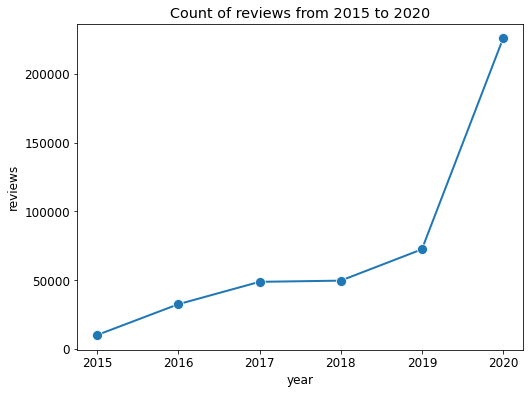

In [219]:
mpl.rcParams['font.size']= 12
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(x=yr_reviews.index, y = 'reviews', data = yr_reviews, marker='o',ax=ax, markersize=10, lw=2 );
plt.title('Count of reviews from 2015 to 2020');

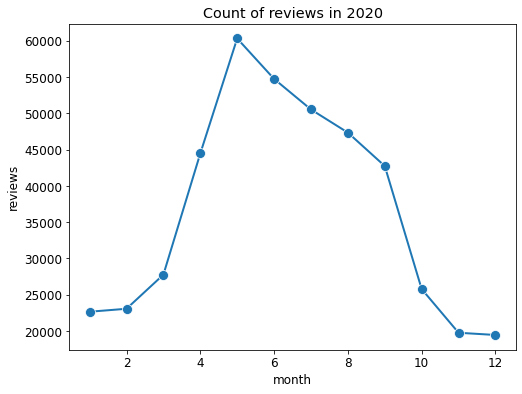

In [218]:
df_2020 = df[df['year']=='2020']
reviews_2020 = pd.DataFrame(df.groupby('month')['reviews'].count())
reviews_2020 = reviews_2020.reset_index()

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x='month', y = 'reviews', data = reviews_2020, marker='o',ax=ax, markersize=10, lw=2);

plt.title('Count of reviews in 2020');

### 7. Data Export to csv file

In [221]:
df.to_csv('df_cleaned.csv', index=False)